In [1]:
# ══ 1) Install / Upgrade Dependencies ════════════════════════════════════════
!pip install --upgrade pip
!pip install --quiet \
    opencv-python-headless \
    pandas \
    matplotlib \
    tqdm \
    scikit-learn \
    tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
# ══ 2) Mount Google Drive ══════════════════════════════════════════════════
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# ══ 3) Imports & Global Settings ═══════════════════════════════════════════
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

import pandas as pd
from sklearn.model_selection import train_test_split

# Paths & Hyperparameters
ROOT                 = '/content/drive/MyDrive/dataset/plantvillage dataset'
COLOR_DIR            = os.path.join(ROOT, 'color')
SAVE_DIR             = '/content/drive/MyDrive/saved_models_color_prodv10'
IMG_SIZE             = (224, 224)
BATCH_SIZE           = 32
NUM_HEAD_EPOCHS      = 15
NUM_FINE_TUNE_EPOCHS = 100
os.makedirs(SAVE_DIR, exist_ok=True)


In [4]:

# ══ 3.1) Resume Helper & Callback Definition ════════════════════════════════
class EpochCheckpoint(Callback):
    """Save model and history after each epoch with unique names."""
    def __init__(self, save_dir, base_name):
        super().__init__()
        self.save_dir = save_dir
        self.base_name = base_name
        self.history_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        ep = epoch + 1
        mpath = os.path.join(self.save_dir, f"{self.base_name}_{ep:02d}.h5")
        self.model.save(mpath)
        self.history_per_epoch.append(logs.copy() if logs else {})
        hpath = os.path.join(self.save_dir, f"history_{self.base_name}_{ep:02d}.pkl")
        with open(hpath, 'wb') as f:
            pickle.dump(self.history_per_epoch, f)


def find_last_checkpoint(save_dir, base_name):
    files = [f for f in os.listdir(save_dir) if re.match(f"{base_name}_\\d+\\.h5", f)]
    if not files:
        return None, None, 0
    epochs = [int(re.findall(r"(\\d+)", f)[0]) for f in files]
    last = max(epochs)
    mpath = os.path.join(save_dir, f"{base_name}_{last:02d}.h5")
    hpath = os.path.join(save_dir, f"history_{base_name}_{last:02d}.pkl")
    return mpath, hpath, last


In [5]:
# ══ 4) Data Generators & Dataset Splits ═══════════════════════════════════════
# 4.1) Build a DataFrame of all grayscale image paths + labels
file_paths, labels = [], []
for cls in os.listdir(COLOR_DIR):
    class_dir = os.path.join(COLOR_DIR, cls)
    for fname in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, fname))
        labels.append(cls)
df = pd.DataFrame({'filename': file_paths, 'class': labels})

# 4.2) Stratified split: 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
val_df, test_df  = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

# 4.3) Define data generators
train_datagen = ImageDataGenerator(
    rescale=1/255., rotation_range=20,
    width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1,
    horizontal_flip=True
)
test_val_datagen = ImageDataGenerator(rescale=1/255.)

# 4.4) Flow from DataFrame
train_ds = train_datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='class',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)
val_ds = test_val_datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)
test_ds = test_val_datagen.flow_from_dataframe(
    test_df, x_col='filename', y_col='class',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

NUM_CLASSES = len(train_ds.class_indices)
print(f"Found {NUM_CLASSES} classes. Samples → train: {train_ds.n}, val: {val_ds.n}, test: {test_ds.n}")

Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.
Found 38 classes. Samples → train: 43444, val: 5430, test: 5431


In [6]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.applications import MobileNetV2

# ══ 5) Build Base Model ══════════════════════════════════════════════════════
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)
base_model.trainable = False

inputs = Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# ══ 6) Stage-1: Head Training (Resumeable) ══════════════════════════════════
head_name = 'MobileNetV2_head'
mp, hp, e0 = find_last_checkpoint(SAVE_DIR, head_name)
if mp:
    print(f"Resuming head training from epoch {e0}")
    model.load_weights(mp)
    initial_ep = e0
else:
    print("Starting head training from scratch")
    initial_ep = 0
cb_head = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    EpochCheckpoint(SAVE_DIR, head_name)
]
history1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=initial_ep + NUM_HEAD_EPOCHS,
    initial_epoch=initial_ep,
    callbacks=cb_head
)
print(f"Head training complete. Latest checkpoint: {head_name}_{initial_ep+NUM_HEAD_EPOCHS:02d}.h5")


Starting head training from scratch


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.7682 - loss: 0.9045 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 39426s 29s/step - accuracy: 0.7683 - loss: 0.9042 - val_accuracy: 0.9208 - val_loss: 0.2593 - learning_rate: 0.0010
Epoch 2/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9317 - loss: 0.2204

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 551s 406ms/step - accuracy: 0.9317 - loss: 0.2204 - val_accuracy: 0.9263 - val_loss: 0.2217 - learning_rate: 0.0010
Epoch 3/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9439 - loss: 0.1747

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 552s 407ms/step - accuracy: 0.9439 - loss: 0.1747 - val_accuracy: 0.9403 - val_loss: 0.1905 - learning_rate: 0.0010
Epoch 4/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9530 - loss: 0.1466

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 556s 409ms/step - accuracy: 0.9530 - loss: 0.1466 - val_accuracy: 0.9420 - val_loss: 0.1738 - learning_rate: 0.0010
Epoch 5/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9559 - loss: 0.1370

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 553s 407ms/step - accuracy: 0.9559 - loss: 0.1370 - val_accuracy: 0.9361 - val_loss: 0.1792 - learning_rate: 0.0010
Epoch 6/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9579 - loss: 0.1270

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 553s 407ms/step - accuracy: 0.9579 - loss: 0.1270 - val_accuracy: 0.9366 - val_loss: 0.1829 - learning_rate: 0.0010
Epoch 7/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9647 - loss: 0.1060

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 548s 403ms/step - accuracy: 0.9647 - loss: 0.1060 - val_accuracy: 0.9438 - val_loss: 0.1605 - learning_rate: 5.0000e-04
Epoch 8/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9675 - loss: 0.1001

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 550s 405ms/step - accuracy: 0.9675 - loss: 0.1001 - val_accuracy: 0.9477 - val_loss: 0.1541 - learning_rate: 5.0000e-04
Epoch 9/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9683 - loss: 0.0969

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 548s 403ms/step - accuracy: 0.9683 - loss: 0.0969 - val_accuracy: 0.9470 - val_loss: 0.1574 - learning_rate: 5.0000e-04
Epoch 10/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9697 - loss: 0.0944

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 553s 407ms/step - accuracy: 0.9697 - loss: 0.0944 - val_accuracy: 0.9499 - val_loss: 0.1458 - learning_rate: 5.0000e-04
Epoch 11/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9697 - loss: 0.0917

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 552s 407ms/step - accuracy: 0.9697 - loss: 0.0917 - val_accuracy: 0.9442 - val_loss: 0.1589 - learning_rate: 5.0000e-04
Epoch 12/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9695 - loss: 0.0894

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 554s 408ms/step - accuracy: 0.9695 - loss: 0.0894 - val_accuracy: 0.9505 - val_loss: 0.1469 - learning_rate: 5.0000e-04
Epoch 13/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9726 - loss: 0.0835

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 550s 405ms/step - accuracy: 0.9726 - loss: 0.0835 - val_accuracy: 0.9475 - val_loss: 0.1501 - learning_rate: 2.5000e-04
Head training complete. Latest checkpoint: MobileNetV2_head_15.h5


Stage 1 final → Train Acc: 0.9723, Val Acc: 0.9475


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


170/170 ━━━━━━━━━━━━━━━━━━━━ 4333s 26s/step - accuracy: 0.9461 - loss: 0.1573
Stage 1 final → Test Loss: 0.1442, Test Acc: 0.9514


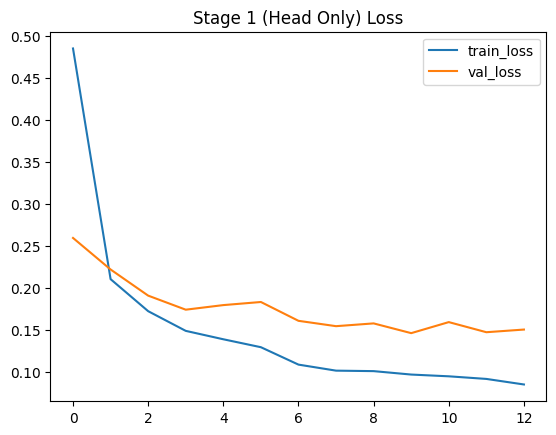

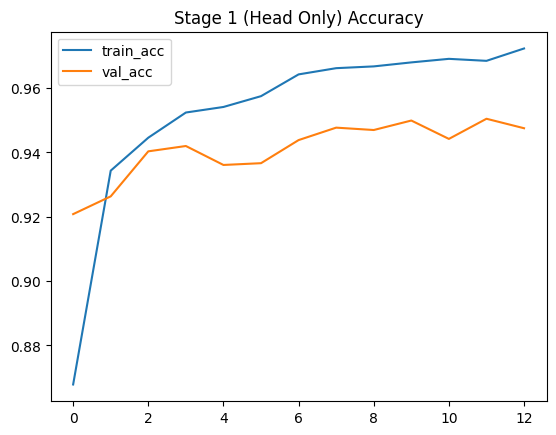

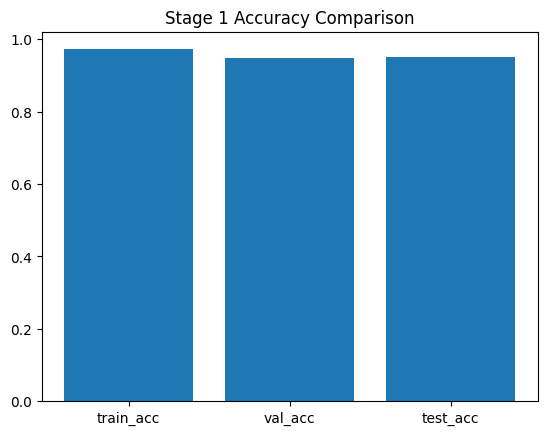

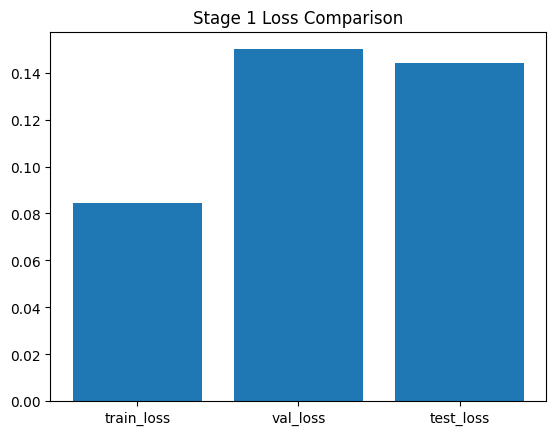

In [8]:
# ══ 8) Plot & Print Stage-1 Metrics & Test Evaluation ═════════════════════════════════════════
def plot_history(hist, stage):
    plt.figure()
    plt.plot(hist.history['loss'],     label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(f'{stage} Loss');    plt.legend()
    plt.figure()
    plt.plot(hist.history['accuracy'],     label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.title(f'{stage} Accuracy'); plt.legend()

# 8.1) Head-only training curves
plot_history(history1, 'Stage 1 (Head Only)')

train_acc1 = history1.history['accuracy'][-1]
val_acc1   = history1.history['val_accuracy'][-1]
print(f"Stage 1 final → Train Acc: {train_acc1:.4f}, Val Acc: {val_acc1:.4f}")

# 8.2) Evaluate head-only model on your held-out test set
test_loss1, test_acc1 = model.evaluate(test_ds, verbose=1)
print(f"Stage 1 final → Test Loss: {test_loss1:.4f}, Test Acc: {test_acc1:.4f}")

# 8.3) Bar-chart comparison for Stage 1
plt.figure()
plt.bar(['train_acc','val_acc','test_acc'], [train_acc1, val_acc1, test_acc1])
plt.title('Stage 1 Accuracy Comparison')
plt.show()

plt.figure()
plt.bar(
    ['train_loss','val_loss','test_loss'],
    [history1.history['loss'][-1], history1.history['val_loss'][-1], test_loss1]
)
plt.title('Stage 1 Loss Comparison')
plt.show()


In [9]:
# ══ 9) Stage-2: Fine-Tuning (Resumeable) ═══════════════════════════════════
for layer in base_model.layers[-30:]:
    layer.trainable = True
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
fine_name = 'rMobileNetV2_finetuned'
mp2, hp2, e1 = find_last_checkpoint(SAVE_DIR, fine_name)
if mp2:
    print(f"Resuming fine-tuning from epoch {e1}")
    model.load_weights(mp2)
    initial_ft = e1
else:
    print("Starting fine-tuning from scratch")
    initial_ft = 0
cb_ft = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7),
    EpochCheckpoint(SAVE_DIR, fine_name)
]
history2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=initial_ft + NUM_FINE_TUNE_EPOCHS,
    initial_epoch=initial_ft,
    callbacks=cb_ft
)
print(f"Fine-tuning complete. Latest checkpoint: {fine_name}_{initial_ft+NUM_FINE_TUNE_EPOCHS:02d}.h5")


Starting fine-tuning from scratch
Epoch 1/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8352 - loss: 0.6618

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 577s 414ms/step - accuracy: 0.8353 - loss: 0.6616 - val_accuracy: 0.9459 - val_loss: 0.1696 - learning_rate: 1.0000e-05
Epoch 2/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9437 - loss: 0.1670

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 553s 407ms/step - accuracy: 0.9437 - loss: 0.1670 - val_accuracy: 0.9532 - val_loss: 0.1512 - learning_rate: 1.0000e-05
Epoch 3/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9587 - loss: 0.1232

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 549s 404ms/step - accuracy: 0.9587 - loss: 0.1232 - val_accuracy: 0.9543 - val_loss: 0.1339 - learning_rate: 1.0000e-05
Epoch 4/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9665 - loss: 0.0972

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 551s 405ms/step - accuracy: 0.9665 - loss: 0.0972 - val_accuracy: 0.9565 - val_loss: 0.1291 - learning_rate: 1.0000e-05
Epoch 5/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9715 - loss: 0.0844

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 565s 416ms/step - accuracy: 0.9715 - loss: 0.0844 - val_accuracy: 0.9611 - val_loss: 0.1136 - learning_rate: 1.0000e-05
Epoch 6/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9748 - loss: 0.0752

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 564s 415ms/step - accuracy: 0.9748 - loss: 0.0752 - val_accuracy: 0.9611 - val_loss: 0.1130 - learning_rate: 1.0000e-05
Epoch 7/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9788 - loss: 0.0623

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 563s 414ms/step - accuracy: 0.9788 - loss: 0.0623 - val_accuracy: 0.9635 - val_loss: 0.1072 - learning_rate: 1.0000e-05
Epoch 8/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9807 - loss: 0.0585

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 567s 417ms/step - accuracy: 0.9807 - loss: 0.0585 - val_accuracy: 0.9692 - val_loss: 0.0920 - learning_rate: 1.0000e-05
Epoch 9/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9833 - loss: 0.0491

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 564s 415ms/step - accuracy: 0.9833 - loss: 0.0491 - val_accuracy: 0.9692 - val_loss: 0.0923 - learning_rate: 1.0000e-05
Epoch 10/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9855 - loss: 0.0418

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 577s 425ms/step - accuracy: 0.9855 - loss: 0.0418 - val_accuracy: 0.9705 - val_loss: 0.0897 - learning_rate: 1.0000e-05
Epoch 11/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9862 - loss: 0.0385

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 568s 418ms/step - accuracy: 0.9862 - loss: 0.0385 - val_accuracy: 0.9718 - val_loss: 0.0845 - learning_rate: 1.0000e-05
Epoch 12/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9863 - loss: 0.0400

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 569s 419ms/step - accuracy: 0.9863 - loss: 0.0399 - val_accuracy: 0.9685 - val_loss: 0.0924 - learning_rate: 1.0000e-05
Epoch 13/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9882 - loss: 0.0351

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 563s 414ms/step - accuracy: 0.9882 - loss: 0.0351 - val_accuracy: 0.9726 - val_loss: 0.0860 - learning_rate: 1.0000e-05
Epoch 14/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9878 - loss: 0.0347

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 560s 412ms/step - accuracy: 0.9878 - loss: 0.0347 - val_accuracy: 0.9729 - val_loss: 0.0843 - learning_rate: 5.0000e-06
Epoch 15/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9902 - loss: 0.0299

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 560s 412ms/step - accuracy: 0.9902 - loss: 0.0299 - val_accuracy: 0.9755 - val_loss: 0.0771 - learning_rate: 5.0000e-06
Epoch 16/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9927 - loss: 0.0235

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 565s 416ms/step - accuracy: 0.9927 - loss: 0.0235 - val_accuracy: 0.9751 - val_loss: 0.0819 - learning_rate: 5.0000e-06
Epoch 17/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9907 - loss: 0.0271

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 565s 416ms/step - accuracy: 0.9907 - loss: 0.0271 - val_accuracy: 0.9746 - val_loss: 0.0815 - learning_rate: 5.0000e-06
Epoch 18/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9925 - loss: 0.0225

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 565s 416ms/step - accuracy: 0.9925 - loss: 0.0225 - val_accuracy: 0.9772 - val_loss: 0.0769 - learning_rate: 2.5000e-06
Epoch 19/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9920 - loss: 0.0238

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 560s 412ms/step - accuracy: 0.9920 - loss: 0.0238 - val_accuracy: 0.9764 - val_loss: 0.0752 - learning_rate: 2.5000e-06
Epoch 20/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9924 - loss: 0.0231

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 559s 412ms/step - accuracy: 0.9924 - loss: 0.0231 - val_accuracy: 0.9751 - val_loss: 0.0771 - learning_rate: 2.5000e-06
Epoch 21/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9928 - loss: 0.0219

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 563s 415ms/step - accuracy: 0.9928 - loss: 0.0219 - val_accuracy: 0.9762 - val_loss: 0.0750 - learning_rate: 2.5000e-06
Epoch 22/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9935 - loss: 0.0212

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 561s 413ms/step - accuracy: 0.9935 - loss: 0.0212 - val_accuracy: 0.9775 - val_loss: 0.0731 - learning_rate: 2.5000e-06
Epoch 23/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9923 - loss: 0.0221

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 564s 416ms/step - accuracy: 0.9923 - loss: 0.0221 - val_accuracy: 0.9775 - val_loss: 0.0738 - learning_rate: 2.5000e-06
Epoch 24/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9937 - loss: 0.0198

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 560s 412ms/step - accuracy: 0.9937 - loss: 0.0198 - val_accuracy: 0.9751 - val_loss: 0.0786 - learning_rate: 2.5000e-06
Epoch 25/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9941 - loss: 0.0194

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 560s 412ms/step - accuracy: 0.9941 - loss: 0.0194 - val_accuracy: 0.9761 - val_loss: 0.0766 - learning_rate: 1.2500e-06
Fine-tuning complete. Latest checkpoint: rMobileNetV2_finetuned_100.h5


Stage 2 final → Train Acc: 0.9936, Val Acc: 0.9761
170/170 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.9742 - loss: 0.0997
Stage 2 final → Test Loss: 0.0794, Test Acc: 0.9759


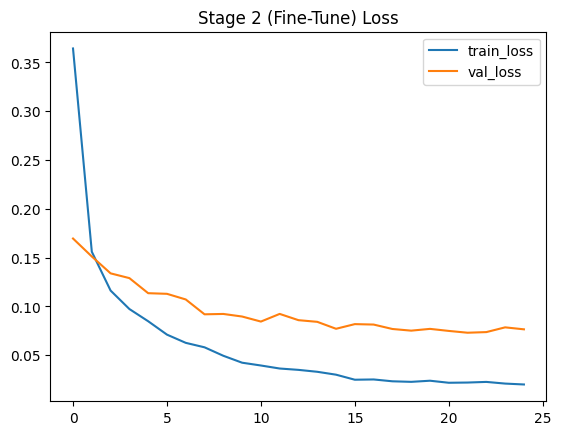

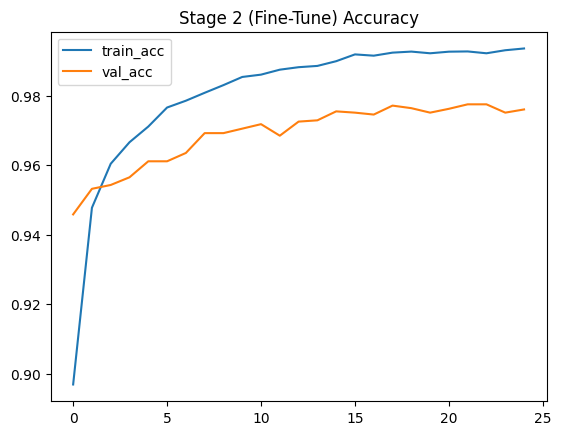

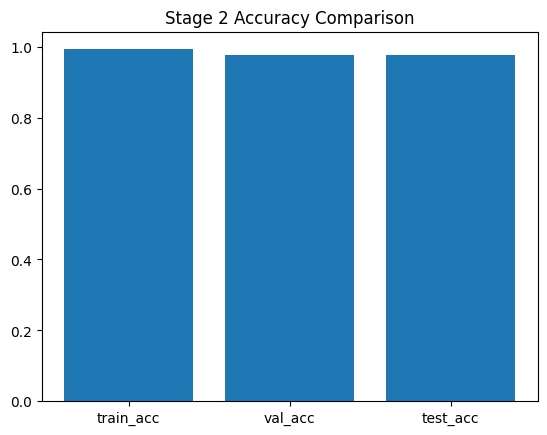

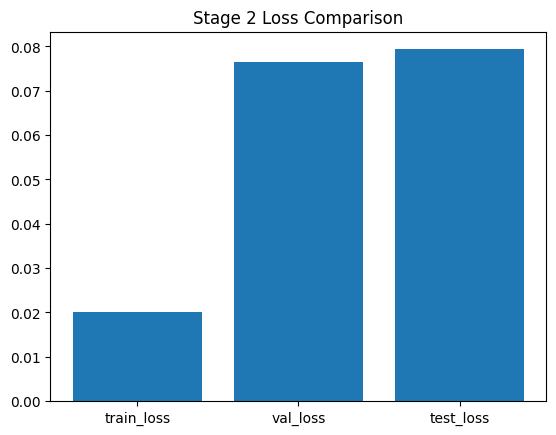

In [10]:
# ══ 10) Plot & Print Stage-2 Metrics & Test Evaluation ══════════════════════════
plot_history(history2, 'Stage 2 (Fine-Tune)')

train_acc2 = history2.history['accuracy'][-1]
val_acc2   = history2.history['val_accuracy'][-1]
print(f"Stage 2 final → Train Acc: {train_acc2:.4f}, Val Acc: {val_acc2:.4f}")

# 10.1) Evaluate on your held-out test set
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Stage 2 final → Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# 10.2) Comparison bar-charts
plt.figure()
plt.bar(['train_acc','val_acc','test_acc'], [train_acc2, val_acc2, test_acc])
plt.title('Stage 2 Accuracy Comparison')
plt.show()

plt.figure()
plt.bar(
    ['train_loss','val_loss','test_loss'],
    [history2.history['loss'][-1], history2.history['val_loss'][-1], test_loss]
)
plt.title('Stage 2 Loss Comparison')
plt.show()


In [11]:
val_loss, val_acc = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - accuracy: 0.9754 - loss: 0.0863
Validation Loss: 0.0731, Validation Accuracy: 0.9775
